# **Homework | PH3406 - Open Quantum Systems**
### *Oscar Stommendal, Spring 2025*

In [331]:
### Libraries and plot settings ###

# Libraries
import numpy as np
import sympy as sp
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Latex style
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=18)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

# Set ticks on both sides
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True


### **Problem 1 - Quantum State Tomography**

In the first problem, we want to perform quantum state tomography in order to recreate a state from measurement outcomes as input data. Below, I start by reading data and computing the optimal Bloch vector, $\vec{v}$, according to direct inversion (DI), which is the mean of the measurements for each $\sigma_i$. However, since the resulting Bloch vector has a norm larger than 1, this is an un-physical result (density matrix representation). Therefore, we apply a Bayesian approach next in order to avoid this problem.

In [332]:
### Data collection and direct inversion solution ###

# Read data
sigma_x, sigma_y, sigma_z = np.loadtxt('content/hw_prob_data.txt', unpack=True)

v_x_DI = np.mean(sigma_x) # Direct inversion mean of the x component of the Bloch vector
v_y_DI = np.mean(sigma_y) # Direct inversion mean of the y component of the Bloch vector
v_z_DI = np.mean(sigma_z) # Direct inversion mean of the z component of the Bloch vector

# Display the direct inversion solution
display(Markdown('### Direct inversion ###'))
display(Markdown('Direct inversion solution: ' + f'$[v_x,\\,v_y,\\,v_z]$ = [{v_x_DI:.3f}, {v_y_DI:.3f}, {v_z_DI:.3f}]'))
display(Markdown('Norm of the Bloch vector: ' + f'$||v|| = {np.linalg.norm([v_x_DI, v_y_DI, v_z_DI]):.3f}$'))


### Direct inversion ###

Direct inversion solution: $[v_x,\,v_y,\,v_z]$ = [0.392, -0.336, 0.876]

Norm of the Bloch vector: $||v|| = 1.017$

Below, I have defined the three components of the Bayesian approach to the problem – the log-prior, likelihood and posterior functions, which are connected according to
$$
\log{\underbrace{\mathcal{P}(\hat{\rho}\vert N_{x+}, N_{x-}, N_{y+}, N_{y-}, N_{z+}, N_{z-})}_{Posterior}} \propto \log{\underbrace{\mathcal{P}(\hat{\rho})}_{Prior}} + \log{\underbrace{\mathcal{P}(N_{x+}, N_{x-}, N_{y+}, N_{y-}, N_{z+}, N_{z-}\vert\hat{\rho})}_{Likelihood}}
$$ 
As outlined by the lecture notes, we use a Hilbert-Schmidt-prior, i.e.
$$
\mathcal{P}_{HS} = \begin{cases}1 \,\,\,\, \text{if} \,\,\,\, \|\vec{v}\| \leq 1, \\ 0 \,\,\,\, \text{if} \,\,\,\, \|\vec{v}\| > 1.\end{cases}
$$
and the likelihood defined as
$$
\mathcal{P}(N_{x+}, N_{x-}, N_{y+}, N_{y-}, N_{z+}, N_{z-}\vert\hat{\rho}) \propto \exp{\left(-\frac{(N_{x+}-\mu_{x+})^2}{2\sigma_{x+}^2}\right)} \times \exp{\left(-\frac{(N_{y+}-\mu_{y+})^2}{2\sigma_{y+}^2}\right)} \times \exp{\left(-\frac{(N_{z+}-\mu_{z+})^2}{2\sigma_{z+}^2}\right)}.
$$
Here, $\mu_{i+} = N_i\,\frac{(1 + \vec{v}_i)}{2}$ and $\sigma^2_{i+} = N_i\,\frac{(1 + \vec{v}_i)}{2}\,\frac{(1 - \vec{v}_i)}{2}$, with $N_i = N_{i+} + N_{i-}$.


In [333]:
### Function definitions ###

N = len(sigma_x) # Number of measurements

def log_prior(bloch_vector):
    '''
    Returns the log of the prior probability.

    Args:
        bloch_vector (np.array): Bloch vector.
    
    Returns:
        float: Log of the prior probability.
    '''
    # If the norm of the Bloch vector is less than or equal to 1, return 0
    if np.abs(np.linalg.norm(bloch_vector) - 1) <= 0.001:
        return 0
    # Otherwise, return negative infinity
    else:
        return -np.inf

def log_likelihood(N_i_plus, bloch_vector):
    '''
    Returns the log of the likelihood function from the lecture notes.

    Args:
        N_i_plus (np.array): Array of number of measurement outcomes in the positive direction for each axis.
        bloch_vector (np.array): Bloch vector.
    
    Returns:
        float: Log of the likelihood.
    '''
    mu_x_plus = N * (1 + bloch_vector[0]) / 2 # Mean of the x outcome in positive direction
    variance_x_plus = N * (1 - bloch_vector[0]**2) / 4 # Variance of the x outcome in positive direction
    mu_y_plus = N * (1 + bloch_vector[1]) / 2 # Mean of the y outcome in positive direction
    variance_y_plus = N * (1 - bloch_vector[1]**2) / 4 # Variance of the y outcome in positive direction
    mu_z_plus = N * (1 + bloch_vector[2]) / 2 # Mean of the z outcome in positive direction
    variance_z_plus = N * (1 - bloch_vector[2]**2) / 4 # Variance of the z outcome in positive direction

    # Return the log of the likelihood function using the formula from the lecture notes
    return - ((N_i_plus[0] - mu_x_plus)**2 / (2 * variance_x_plus) + (N_i_plus[1] - mu_y_plus)**2 / (2 * variance_y_plus) + (N_i_plus[2] - mu_z_plus)**2 / (2 * variance_z_plus))

def log_posterior(N_i_plus, bloch_vector):
    '''
    Returns the log of the posterior probability.

    Args:
        N_i_plus (np.array): Array of number of measurement outcomes in the positive direction for each axis.
        bloch_vector (np.array): Bloch vector.
    
    Returns:
        float: Log of the posterior probability.
    '''
    return log_prior(bloch_vector) + log_likelihood(N_i_plus, bloch_vector)


Below, I evaluate the posterior over a grid of different Bloch vectors with components ranging from -1.5 to 1.5. Afterwards, I compute the mean Bloch vector and the standard deviation for each components. The result is a Bloch vector with norm less than 1, which seems reasonable since this was a part of the goal using this method. From the mean Bloch vector found, I finally compute the density matrix for the system according to
$$
\hat{\rho} = \frac{1}{2}(\mathbb{I} + \vec{v}_x\cdot X + \vec{v}_y\cdot Y + \vec{v}_z\cdot Z).
$$
As a final check, I compute the trace of this density matrix, which was evaluated to 1 – ensuring a physical result.


In [334]:
### Evaluate the posterior and analyze the results ###

# Calculate number of positive spins
N_x_plus = np.sum(sigma_x > 0)
N_y_plus = np.sum(sigma_y > 0)
N_z_plus = np.sum(sigma_z > 0)

# Create a grid of Bloch vectors
x = np.linspace(-1.5, 1.5, 100)
y = np.linspace(-1.5, 1.5, 100)
z = np.linspace(-1.5, 1.5, 100)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij') 

# ChatGPT's solution to get a vectorized evaluation of the posterior
bloch_vectors = np.stack((X, Y, Z), axis=-1) # Bloch vector grid (50x50x50x3)
posterior_log = np.apply_along_axis(lambda v: log_posterior([N_x_plus, N_y_plus, N_z_plus], v), -1, bloch_vectors) # Log posterior grid (50x50x50)

# Normalize the posterior
posterior = np.exp(posterior_log)
posterior /= np.sum(posterior)

# Calculate the mean and standard deviation of the Bloch vector
mean_x = np.sum(X * posterior) # Mean of the x component of the Bloch vector
mean_y = np.sum(Y * posterior) # Mean of the y component of the Bloch vector
mean_z = np.sum(Z * posterior) # Mean of the z component of the Bloch vector
mean = np.array([mean_x, mean_y, mean_z]) # Mean Bloch vector

std_x = np.sqrt(np.sum((X - mean_x)**2 * posterior)) # Standard deviation of the x component of the Bloch vector
std_y = np.sqrt(np.sum((Y - mean_y)**2 * posterior)) # Standard deviation of the y component of the Bloch vector
std_z = np.sqrt(np.sum((Z - mean_z)**2 * posterior)) # Standard deviation of the z component of the Bloch vector
std = np.array([std_x, std_y, std_z]) # Standard deviation of the Bloch vector

# Calculate the actual density matrix from the mean Bloch vector
rho = 0.5 * (np.eye(2) + mean[0] * sp.Matrix([[0, 1], [1, 0]]) + mean[1] * sp.Matrix([[0, -1j], [1j, 0]]) + mean[2] * sp.Matrix([[1, 0], [0, -1]]))

# Display the results with Markdown
display(Markdown("### Results with Probability Method"))
display(Markdown(f"Mean Bloch vector: {mean.round(4)}"))
display(Markdown(f"Length of mean Bloch vector: {np.linalg.norm(mean):.4f}"))
display(Markdown(f"Standard deviation: {std.round(4)}"))
display(Markdown("Actual density matrix:"))
display(rho.evalf(4))
display(Markdown(f"Trace of the density matrix: {np.trace(rho):.4f}"))


### Results with Probability Method

Mean Bloch vector: [ 0.3182 -0.3182  0.8939]

Length of mean Bloch vector: 1.0008

Standard deviation: [0. 0. 0.]

Actual density matrix:

⎡      0.947        0.1591 + 0.1591⋅ⅈ⎤
⎢                                    ⎥
⎣0.1591 - 0.1591⋅ⅈ       0.05303     ⎦

Trace of the density matrix: 1.0000

As a bonus, I tried to plot the marginalized distributions for the Bloch vector components along with the mean and standard deviation.

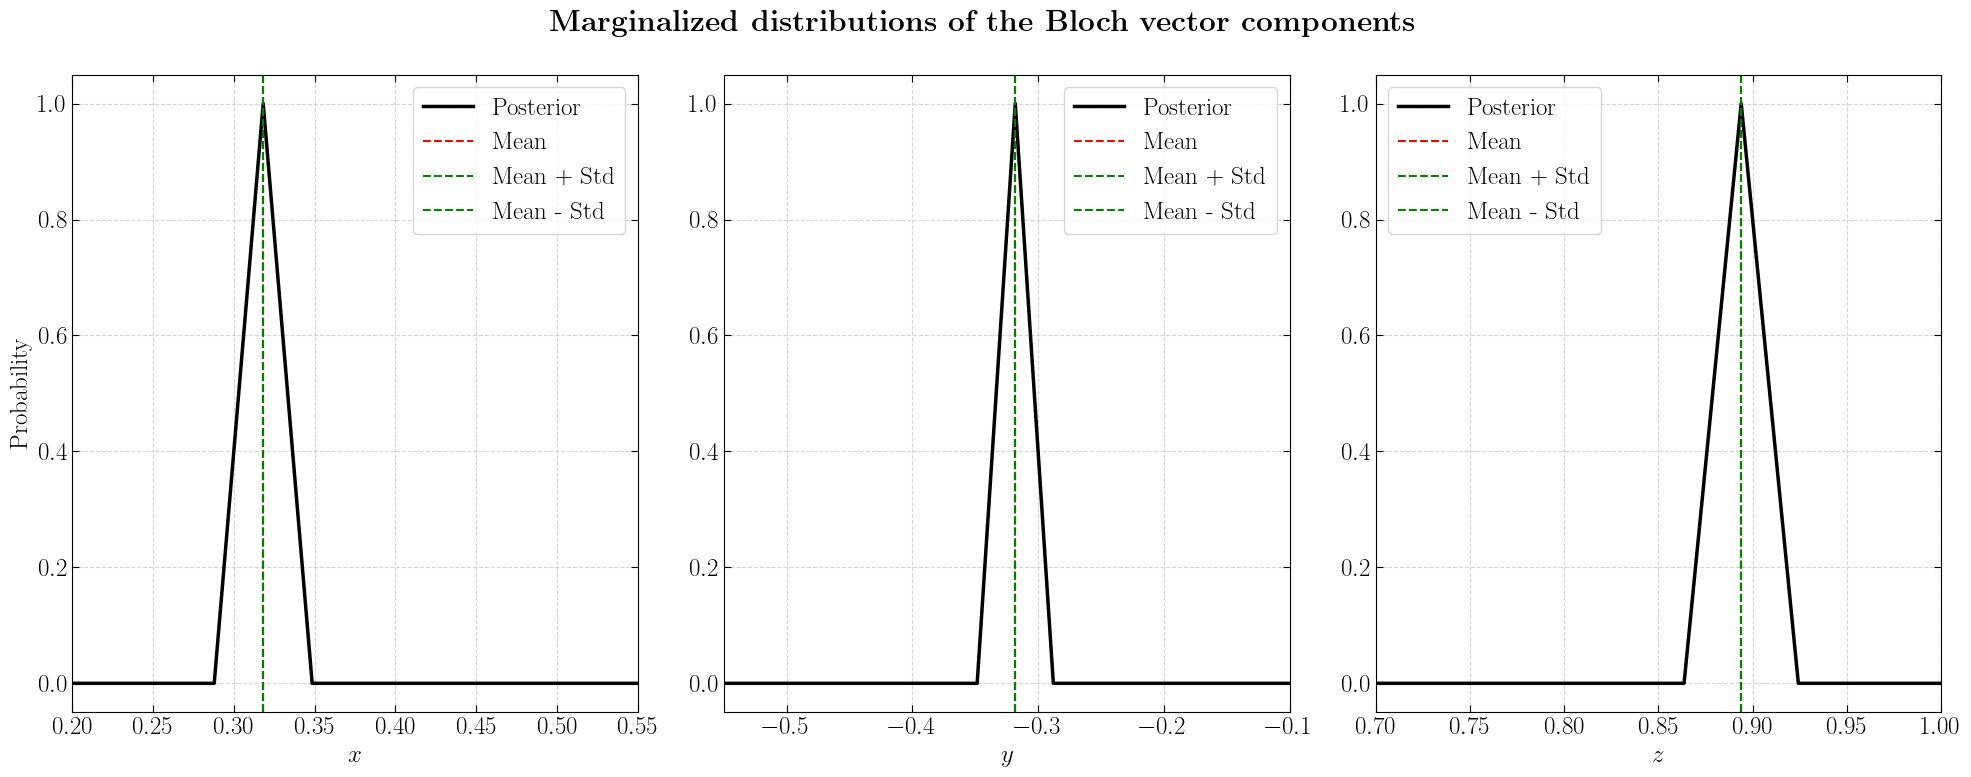

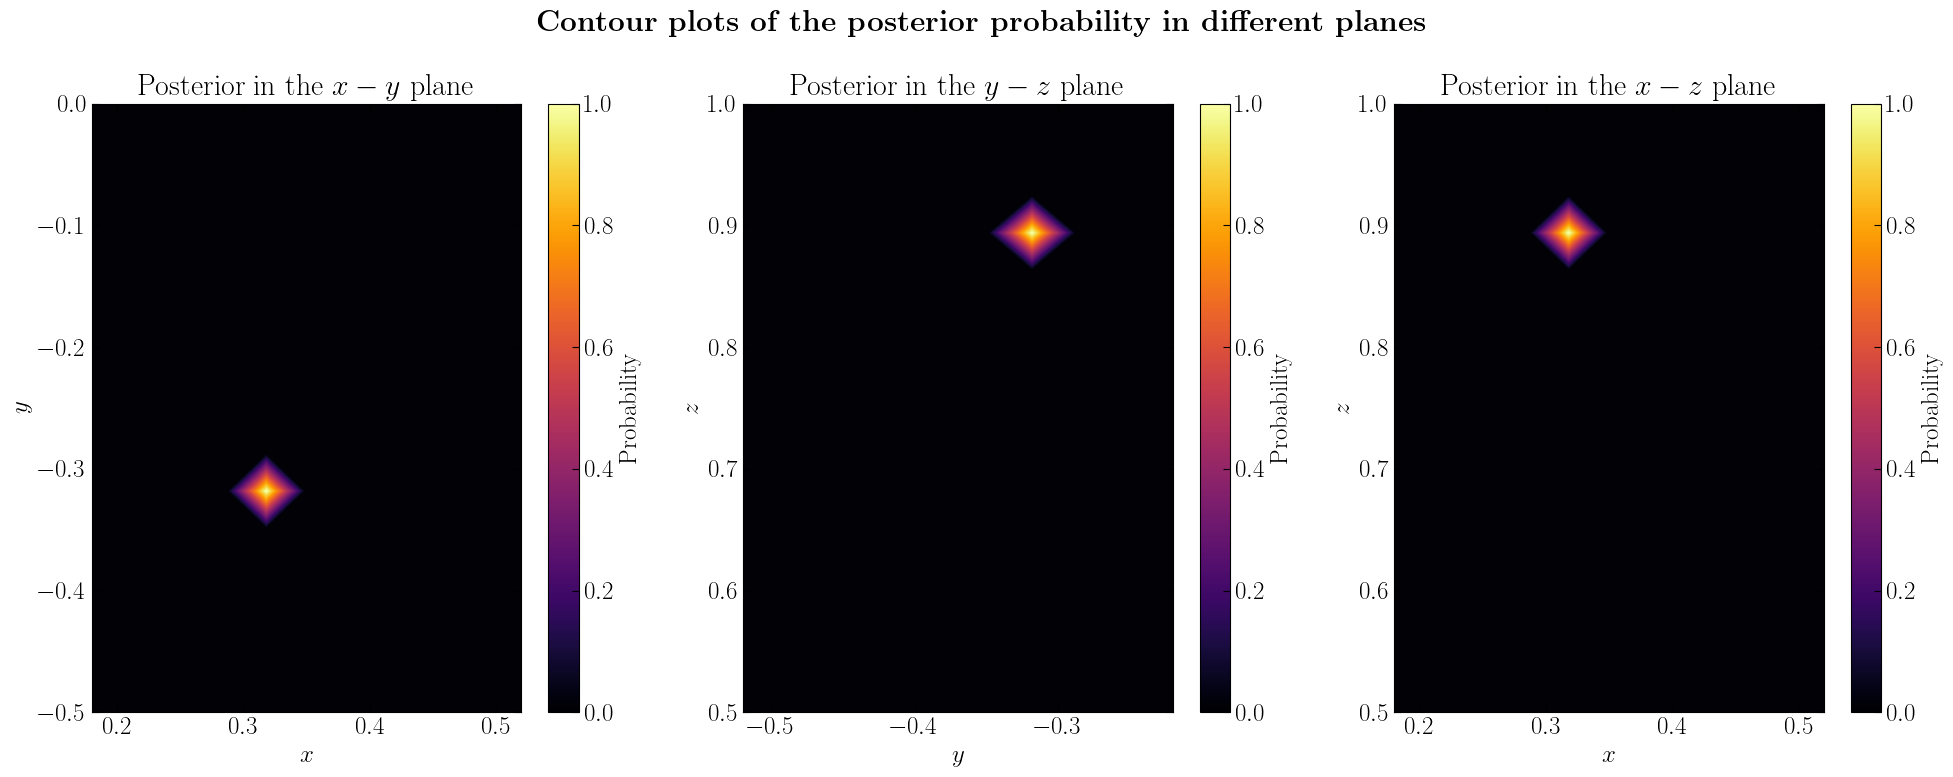

In [335]:
### Bonus: Plotting the marginalized distributions ###

# Plot marginalized distributions of the Bloch vector components
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Plot the x component
axs[0].plot(x, np.sum(np.sum(posterior, axis=1), axis=1), 'k', linewidth=2.5, label='Posterior')
axs[0].axvline(mean_x, color='r', linestyle='--', label='Mean', linewidth=1.5)
axs[0].axvline(mean_x + std_x, color='g', linestyle='--', label='Mean + Std', linewidth=1.5)
axs[0].axvline(mean_x - std_x, color='g', linestyle='--', label='Mean - Std', linewidth=1.5)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('Probability')
axs[0].set_xlim(0.2, 0.55)

# Plot the y component
axs[1].plot(y, np.sum(np.sum(posterior, axis=0), axis=1), 'k', linewidth=2.5, label='Posterior')
axs[1].axvline(mean_y, color='r', linestyle='--', label='Mean', linewidth=1.5)
axs[1].axvline(mean_y + std_y, color='g', linestyle='--', label='Mean + Std', linewidth=1.5)
axs[1].axvline(mean_y - std_y, color='g', linestyle='--', label='Mean - Std', linewidth=1.5)
axs[1].set_xlabel('$y$')
axs[1].set_xlim(-0.55, -0.1)

# Plot the z component
axs[2].plot(z, np.sum(np.sum(posterior, axis=0), axis=0), 'k', linewidth=2.5, label='Posterior')
axs[2].axvline(mean_z, color='r', linestyle='--', label='Mean', linewidth=1.5)
axs[2].axvline(mean_z + std_z, color='g', linestyle='--', label='Mean + Std', linewidth=1.5)
axs[2].axvline(mean_z - std_z, color='g', linestyle='--', label='Mean - Std', linewidth=1.5)
axs[2].set_xlabel('$z$')
axs[2].set_xlim(0.7, 1.0)

fig.suptitle('\\textbf{{Marginalized distributions of the Bloch vector components}}')

for ax in axs:
    ax.legend()
    ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

# Plot contourf of the posterior
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Plot the x-y plane
axs[0].contourf(X[:, :, 0], Y[:, :, 0], posterior.sum(axis=2), 50, cmap='inferno')
# axs[0].scatter(mean_x, mean_y, color='y', label='Mean', s=50)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_title('Posterior in the $x-y$ plane')
axs[0].set_xlim(0.18, 0.52)
axs[0].set_ylim(-0.5, 0)
fig.colorbar(plt.cm.ScalarMappable(cmap='inferno'), ax=axs[0], orientation='vertical', label='Probability')

# Plot the y-z plane
axs[1].contourf(Y[0, :, :], Z[0, :, :], posterior.sum(axis=0), 50, cmap='inferno')
# axs[1].scatter(mean_y, mean_z, color='y', label='Mean', s=50)
axs[1].set_xlabel('$y$')
axs[1].set_ylabel('$z$')
axs[1].set_title('Posterior in the $y-z$ plane')
axs[1].set_xlim(-0.52, -0.22)
axs[1].set_ylim(0.5, 1)
fig.colorbar(plt.cm.ScalarMappable(cmap='inferno'), ax=axs[1], orientation='vertical', label='Probability')

# Plot the x-z plane
axs[2].contourf(X[:, 0, :], Z[:, 0, :], posterior.sum(axis=1), 50, cmap='inferno')
# axs[2].scatter(mean_x, mean_z, color='y', label='Mean', s=50)
axs[2].set_xlabel('$x$')
axs[2].set_ylabel('$z$')
axs[2].set_title('Posterior in the $x-z$ plane')
axs[2].set_xlim(0.18, 0.52)
axs[2].set_ylim(0.5, 1)
fig.colorbar(plt.cm.ScalarMappable(cmap='inferno'), ax=axs[2], orientation='vertical', label='Probability')

fig.suptitle('\\textbf{{Contour plots of the posterior probability in different planes}}')

plt.tight_layout()
plt.show()


We can also find the optimal Bloch vector via optimization, which is a bit more straightforward. Since the global maximum of the likelihood is at the direct inversion solution $\vec{v}_{DI}$, we introduce a distance between this vector and an arbitrary Bloch vector $\vec{v}$,
\begin{split}
\mathcal{D} = N_{x+}\,\log{\left(\frac{1 + \vec{v}_{DI, x}}{1 + \vec{v}_x}\right)} &+ N_{x-}\,\log{\left(\frac{1 - \vec{v}_{DI, x}}{1 - \vec{v}_x}\right)} + \\ N_{y+}\,\log{\left(\frac{1 + \vec{v}_{DI, y}}{1 + \vec{v}_y}\right)} &+ N_{y-}\,\log{\left(\frac{1 +- \vec{v}_{DI, y}}{1 - \vec{v}_y}\right)} + \\ N_{z+}\,\log{\left(\frac{1 + \vec{v}_{DI, z}}{1 + \vec{v}_z}\right)} &+ N_{z-}\,\log{\left(\frac{1 - \vec{v}_{DI, z}}{1 - \vec{v}_z}\right)}.
\end{split}
The optimal Bloch vector $\vec{v}^\star$ will then be the vector that minimizes this function.

Below, I perform this optimization using scipy, with a constraint function that make sure we only consider vectors with $\|\vec{v}\| \leq 1$.

In [336]:

def objective_fun(bloch_vector):
    '''
    Returns the objective function to be minimized.

    Args:
        bloch_vector (np.array): Bloch vector.
    
    Returns:
        float: Objective function value.
    '''
    N_x_plus = np.sum(sigma_x > 0)
    N_x_minus = N - N_x_plus
    N_y_plus = np.sum(sigma_y > 0)
    N_y_minus = N - N_y_plus
    N_z_plus = np.sum(sigma_z > 0)
    N_z_minus = N - N_z_plus

    epsilon = 0.0001

    return N_x_plus*np.log(np.clip((1 + v_x_DI + epsilon) / (1 + bloch_vector[0] + epsilon), 1e-10, None)) + N_x_minus*np.log(np.clip((1 - v_x_DI + epsilon) / (1 - bloch_vector[0] + epsilon), 1e-10, None)) + N_y_plus*np.log(np.clip((1 + v_y_DI + epsilon) / (1 + bloch_vector[1] + epsilon), 1e-10, None)) + N_y_minus*np.log(np.clip((1 - v_y_DI + epsilon) / (1 - bloch_vector[1] + epsilon), 1e-10, None)) + N_z_plus*np.log(np.clip((1 + v_z_DI + epsilon) / (1 + bloch_vector[2] + epsilon), 1e-10, None)) + N_z_minus*np.log(np.clip((1 - v_z_DI + epsilon) / (1 - bloch_vector[2] + epsilon), 1e-10, None))

def constraint(bloch_vector):
    '''
    Returns the constraint function to be satisfied.

    Args:
        bloch_vector (np.array): Bloch vector.
    
    Returns:
        float: Constraint function value.
    '''
    return 1 - np.linalg.norm(bloch_vector)

constraint = {'type': 'ineq', 'fun': constraint}

# Minimize the objective function
result = minimize(objective_fun, np.array([0., 0., 0.]), constraints=constraint)
bloch = result.x

# Calculate the actual density matrix from the mean Bloch vector
rho = 0.5 * (np.eye(2) + bloch[0] * sp.Matrix([[0, 1], [1, 0]]) + bloch[1] * sp.Matrix([[0, -1j], [1j, 0]]) + bloch[2] * sp.Matrix([[1, 0], [0, -1]]))

# Display the results with Markdown
display(Markdown("### Results with Optimization Method"))
display(Markdown(f"Bloch vector: {bloch.round(4)}"))
display(Markdown(f"Length of the Bloch vector: {np.linalg.norm(bloch):.4f}"))
display(Markdown("Actual density matrix:"))
display(rho.evalf(4))
display(Markdown(f"Trace of the density matrix: {np.trace(rho):.4f}"))


### Results with Optimization Method

Bloch vector: [ 0.3785 -0.3239  0.8671]

Length of the Bloch vector: 1.0000

Actual density matrix:

⎡     0.9335       0.1892 + 0.162⋅ⅈ⎤
⎢                                  ⎥
⎣0.1892 - 0.162⋅ⅈ      0.06646     ⎦

Trace of the density matrix: 1.0000

### *Last comments on the two methods*

Both methods gives similar results, but not exactly the same. However, I had to tweak the prior function in order to receive a solution that had a norm somewhat close to 1. Depending on how I tweak it (now the prior is 1 if the norm is between 0.999 and 1.001 and 0 else) I get different results, although in the same region of the values of the Bloch vector components. Also, the first method is somewhat of an approximation with the Gaussian expression, which might explain the different outcomes for the methods.

### **Problem 2 - Quantum Process Tomography**

In this problem, we want to compute the $\chi$-matrix using quantum process tomography. We are given the basis of operators and states – $\{\hat{A}_m\}$ and $\{\hat{\rho}_j\}$, where

\begin{aligned}
\{\hat{A}_m\} &= \{\mathbb{I},\, X,\, -iY,\, Z\} \\
\{\hat{\rho}_j\} &= \{\ket{0}\bra{0},\, \ket{0}\bra{1},\, \ket{1}\bra{0},\, \ket{1}\bra{1}\}
\end{aligned}

Using these as given in example 5.9, we are also given the density matrices resulting from measurements – $\{\hat{\rho}_j'\}$, which are
$$
\hat{\rho}_0' = \begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix}, \,\,\,\,\, \hat{\rho}_1' = \begin{pmatrix} 0 & \sqrt{1-\gamma} \\ 0 & 0 \end{pmatrix}, \,\,\,\,\, \hat{\rho}_2' = \begin{pmatrix} 0 & 0 \\ \sqrt{1-\gamma} & 0 \end{pmatrix}, \,\,\,\,\, \hat{\rho}_3' = \begin{pmatrix} \gamma & 0 \\ 0 & 1 - \gamma \end{pmatrix}.
$$
Here, $\gamma$ is a numerical parameter, where we will consider the two cases $\gamma = 0$ and $\gamma = 0.15$.

Below, I have started by defining these matrices as dictionaries for easy access during the following calculations. I also define the parameter $\gamma$ as a sympy-variable in order to keep it and retrieve an analytical result.


In [320]:
### Initialize the problem ###

# Define the gamma parameter as a symbol using sympy
gamma = sp.Symbol('gamma')

# Define known variables
A_m = { # A_hat operators: I, X, -iY, Z
    '0': np.array([[1, 0], [0, 1]]), # A_0
    '1': np.array([[0, 1], [1, 0]]), # A_1
    '2': np.array([[0, -1], [1, 0]]), # A_2
    '3': np.array([[1, 0], [0, -1]]) # A_3
}
rho_j = { # Rho_j operators: |0><0|, |0><1|, |1><0|, |1><1|
    '0': np.array([[1, 0], [0, 0]]),
    '1': np.array([[0, 1], [0, 0]]),
    '2': np.array([[0, 0], [1, 0]]),
    '3': np.array([[0, 0], [0, 1]])
}
rho_j_prime = { # Rho_j' operators found by the method in example 5.9
    '0': sp.Matrix([[1, 0], [0, 0]]),
    '1': sp.Matrix([[0, sp.sqrt(1-gamma)], [0, 0]]),
    '2': sp.Matrix([[0, 0], [sp.sqrt(1-gamma), 0]]),
    '3': sp.Matrix([[gamma, 0], [0, 1-gamma]])
}


Continuing from the given recipe in example 5.9 of the lecture notes, the next step is to compute the $\beta$-matrix. Below, I do this by using the equation 
$$
\hat{A}_m\hat{\rho}_j\hat{A}^\dagger_n = \sum_k \beta^{mn}_{jk}\,\rho_k.
$$
As outlined by the example, I do this for each combination $(m, n)$. This gives me 16 different $4\times 4$ matrices, which I assemble into the $16\times 16$ $\beta$-matrix. 

In practice, I solve the equation above by first rewriting it as a matrix equation (I have to praise ChatGPT for this idea) for every combination of $(m, n)$ and value of $j$ according to
$$
\hat{A}_m\hat{\rho}_j\hat{A}^\dagger_n = \sum_k \beta^{mn}_{jk}\,\rho_k \iff \hat{A}_m\hat{\rho}_j\hat{A}^\dagger_n \equiv Y = \alpha\,\beta^{mn},
$$
where $\beta^{mn}$ is a $4\times 1$ column vector and $\alpha$ is the $4\times 4$ matrix defined as
$$
\alpha \equiv \begin{pmatrix} \vec{\rho_0},\, \vec{\rho_1},\, \vec{\rho}_2,\, \vec{\rho}_3\end{pmatrix} = \mathbb{I}_4.
$$
Here, $\vec{\rho}_j$ is the flattened matrix $\hat{\rho}_j$, i.e.
$$
\vec{\rho_0} = \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix}, \,\,\,\,\, \vec{\rho_1} = \begin{pmatrix} 0 \\ 1 \\ 0 \\ 0 \end{pmatrix}, \,\,\,\,\, \vec{\rho_2} = \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0 \end{pmatrix}, \,\,\,\,\, \vec{\rho_3} = \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1 \end{pmatrix}.
$$


In [325]:
### Find beta matrix elements ###

A = np.eye(4) # A matrix in the matrix equation A*beta = B
combos = [(m, n) for m in range(4) for n in range(4)] # All combinations of m and n

# Initialize the beta matrix
beta_matrix = sp.zeros(16, 16)

# Iterate over the combinations of m and n and calculate beta matrix elements
for m, n in combos:
    # For each j, we solve the matrix equation A*beta_mn = B, where B = A_m * rho_j * A_n^T
    for j in range(4):
        B = A_m[str(m)] @ rho_j[str(j)] @ A_m[str(n)].conj().T # Calculate B matrix
        B = B.flatten().reshape(-1, 1) # Flatten B matrix to a column vector for matrix multiplication
        beta_mn = B # Solve the matrix equation A*beta_mn = B
        # Add the beta matrix elements from the solved beta_mn to the beta dictionary
        for k in range(4):
            beta_matrix[4*j + k, 4*m + n] = beta_mn[k].item()


Next, we compute the $\kappa$-matrix defined as the inverse of the $\beta$-ditto in order to calculate the $\chi$-matrix. This is done using the equation
$$
\chi_{mn} = \sum_j\sum_k = \kappa^{mn}_{jk}\,\lambda_{jk},
$$
where the elements of $\kappa$ are retrieved analogue as for the $\beta$-matrix (however now, we add the elements to the dictionary from the actual matrix in order to access the elements and use the formula above). The $\lambda$-values are given from the density matrices found from experiments according to
$$
\hat{\rho}_0' = \begin{pmatrix} \lambda_{00} & \lambda_{01} \\ \lambda_{02} & \lambda_{03} \end{pmatrix}, \,\,\,\,\, \hat{\rho}_1' = \begin{pmatrix} \lambda_{10} & \lambda_{11} \\ \lambda_{12} & \lambda_{13} \end{pmatrix}, \,\,\,\,\, \hat{\rho}_2' = \begin{pmatrix} \lambda_{20} & \lambda_{21} \\ \lambda_{22} & \lambda_{23} \end{pmatrix}, \,\,\,\,\, \hat{\rho}_3' = \begin{pmatrix} \lambda_{30} & \lambda_{31} \\ \lambda_{32} & \lambda_{33} \end{pmatrix}.
$$
Note here that I have changed so that the indexing starts from 0, which better resembles how it is done in the code.

In [329]:
### Compute the kappa- and chi-matrices ###

# Compute the kappa matrix
kappa_matrix = beta_matrix.inv() # Invert the beta matrix to get the kappa matrix

# Initialize the chi matrix
chi_matrix = sp.zeros(4, 4) 

# Calculate the chi matrix elements using the formula chi_mn = kappa_mn * lambda_jk
for j, k in combos:
    for m, n in combos:
        chi_matrix[j, k] += kappa_matrix[4*j + k, 4*m + n] * rho_j_prime[str(m)].reshape(1, 4)[n] # Calculate the chi matrix elements

# Using the IPython display function to display the results
sp.init_printing()
display(Markdown("### Analytical expression for the $\\chi$ matrix:\n"))
eq = sp.Eq(sp.MatMul(sp.Rational(1/4), sp.Matrix([[(1 + sp.sqrt(1 - gamma))**2, 0, 0, gamma], 
                      [0, gamma, -gamma, 0],
                      [0, -gamma, gamma, 0],
                      [gamma, 0, 0, (1 - sp.sqrt(1 - gamma))**2]])), chi_matrix)
display(eq)
display(Markdown("---"))

display(Markdown("### Case $\\gamma = 0$:\n"))
display(chi_matrix.subs(gamma, 0).evalf(4))
display(Markdown("---"))

display(Markdown("### Case $\\gamma = 0.15$:\n"))
display(chi_matrix.subs(gamma, 0.15).evalf(4))
display(Markdown("---"))


### Analytical expression for the $\chi$ matrix:


                                                   ⎡        _______            ↪
                                                   ⎢  γ   ╲╱ 1 - γ    1        ↪
                                                   ⎢- ─ + ───────── + ─   0    ↪
    ⎡               2                          ⎤   ⎢  4       2       2        ↪
    ⎢⎛  _______    ⎞                           ⎥   ⎢                           ↪
    ⎢⎝╲╱ 1 - γ  + 1⎠   0   0          γ        ⎥   ⎢                      γ    ↪
    ⎢                                          ⎥   ⎢         0            ─    ↪
    ⎢       0          γ   -γ         0        ⎥   ⎢                      4    ↪
1/4⋅⎢                                          ⎥ = ⎢                           ↪
    ⎢       0          -γ  γ          0        ⎥   ⎢                     -γ    ↪
    ⎢                                          ⎥   ⎢         0           ───   ↪
    ⎢                                         2⎥   ⎢                      4    ↪
    ⎢                       

---

### Case $\gamma = 0$:


⎡1.0  0  0  0⎤
⎢            ⎥
⎢ 0   0  0  0⎥
⎢            ⎥
⎢ 0   0  0  0⎥
⎢            ⎥
⎣ 0   0  0  0⎦

---

### Case $\gamma = 0.15$:


⎡0.9235     0        0      0.0375 ⎤
⎢                                  ⎥
⎢  0     0.0375   -0.0375     0    ⎥
⎢                                  ⎥
⎢  0     -0.0375  0.0375      0    ⎥
⎢                                  ⎥
⎣0.0375     0        0     0.001523⎦

---